# Applied machine learning assignment 5


# 1. Transfer Learning for image data using CNN

In [1]:
!unzip -q dataset.zip

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10 - Accuracy: 85.54%
Epoch 2/10 - Accuracy: 98.19%
Epoch 3/10 - Accuracy: 100.00%
Epoch 4/10 - Accuracy: 99.40%
Epoch 5/10 - Accuracy: 100.00%
Epoch 6/10 - Accuracy: 100.00%
Epoch 7/10 - Accuracy: 100.00%
Epoch 8/10 - Accuracy: 100.00%
Epoch 9/10 - Accuracy: 100.00%
Epoch 10/10 - Accuracy: 100.00%


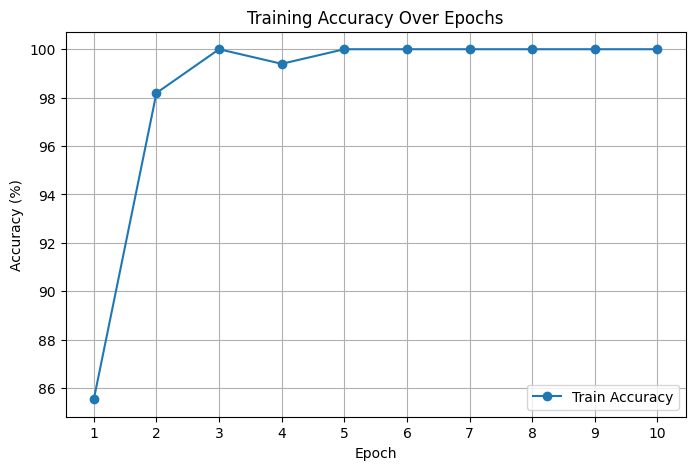


Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.94      0.97        17
        duck       0.94      1.00      0.97        17

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34


Test Accuracy: 97.06%


In [2]:
# required imports
import os
import shutil
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from torchvision.models import resnet18, ResNet18_Weights

# choosing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# setting a seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# dataset
original_dir = 'dataset'
base_dir = 'data_split'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

for cls in ['chicken', 'duck']:
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

    files = os.listdir(os.path.join(original_dir, cls))
    random.shuffle(files)
    split_idx = int(0.83 * len(files))  # ~5:1 ratio
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    for f in train_files:
        shutil.copy(os.path.join(original_dir, cls, f), os.path.join(train_dir, cls, f))
    for f in test_files:
        shutil.copy(os.path.join(original_dir, cls, f), os.path.join(test_dir, cls, f))


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# train and test dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# loading train and test dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# pre-trained ResNet-18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model = model.to(device)

# criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# number of epochs
epochs = 10
train_accuracies = []

# progress bar
total_steps = epochs * len(train_loader)
pbar = tqdm(total=total_steps, desc="Training")

# training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.update(1)

    epoch_acc = 100.0 * correct / total
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs} - Accuracy: {epoch_acc:.2f}%") # printing the accuracies of epochs

pbar.close()

# model evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# plotting the accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, epochs+1))
plt.legend()
plt.show()

# printing the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# test accuracy
test_correct = sum(np.array(all_preds) == np.array(all_labels))
test_total = len(all_labels)
test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# 2. Transfer Learning for text data using Transformer

## downloading the dataset

In [3]:
import kagglehub
import shutil

# Download the dataset
path = kagglehub.dataset_download("abhi8923shriv/sentiment-analysis-dataset")

# copying the dataset in the directory
shutil.copytree(path, "sentiment-analysis-dataset", dirs_exist_ok=True)

'sentiment-analysis-dataset'

In [4]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 15.1 MB/s eta 0:00:00


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3440 [00:00<?, ?it/s]

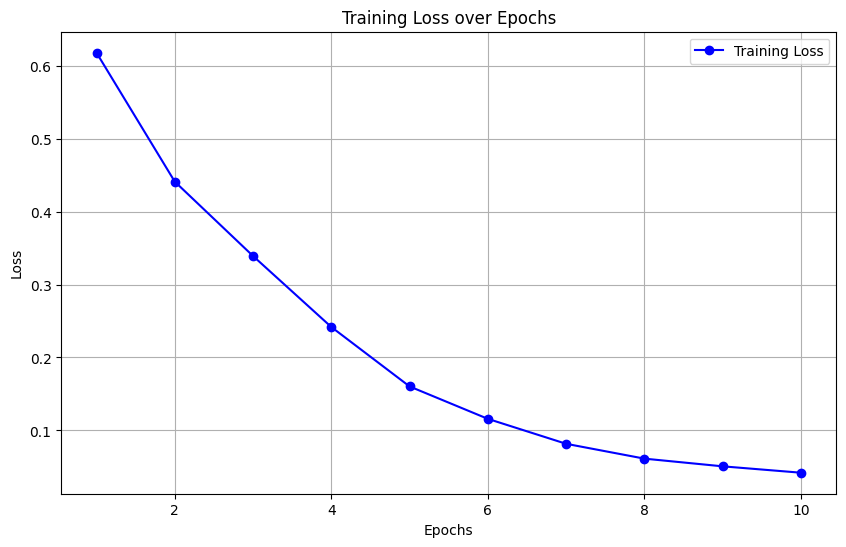


Validation Set Evaluation:
              precision    recall  f1-score   support

    negative       0.80      0.79      0.79       778
     neutral       0.74      0.76      0.75      1111
    positive       0.83      0.81      0.82       859

    accuracy                           0.79      2748
   macro avg       0.79      0.79      0.79      2748
weighted avg       0.79      0.79      0.79      2748


Test Set Evaluation:
              precision    recall  f1-score   support

    negative       0.78      0.79      0.78       778
     neutral       0.74      0.75      0.74      1112
    positive       0.84      0.81      0.82       858

    accuracy                           0.78      2748
   macro avg       0.78      0.78      0.78      2748
weighted avg       0.78      0.78      0.78      2748


Test Accuracy: 77.80%


In [5]:
# required imports
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler
from tqdm.notebook import tqdm
import torch.optim as optim
import os
import matplotlib.pyplot as plt

# device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# loading dataset
df = pd.read_csv("sentiment-analysis-dataset/train.csv", encoding='ISO-8859-1')
df = df[['text', 'sentiment']].copy()
df.dropna(inplace=True)

# encoding sentiment labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

# train-validation-test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.2, random_state=42, stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=42, stratify=temp_labels
)

# loading tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', token=False)

# dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# datasets and dataLoaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True, num_workers=0)

# loading model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', token=False, num_labels=3)
model.to(device)

# optimizer and scheduler
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# mixed precision
scaler = torch.amp.GradScaler()

# track training loss for learning curve
train_losses = []

# training
model.train()
progress_bar = tqdm(range(num_training_steps))

# training loop
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()
        epoch_loss += loss.item()
        progress_bar.update(1)

    # record the average loss for this epoch
    train_losses.append(epoch_loss / len(train_loader))

# plotting training curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# validation Evaluation
model.eval()
val_preds = []
val_labels_list = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.amp.autocast("cuda"):
            outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels_list.extend(batch['labels'].cpu().numpy())

# printing validation evaluation
print("\nValidation Set Evaluation:")
print(classification_report(val_labels_list, val_preds, target_names=label_encoder.classes_))

# test Evaluation
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.amp.autocast("cuda"):
            outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(batch['labels'].cpu().numpy())

# printing test evaluation
print("\nTest Set Evaluation:")
print(classification_report(test_labels_list, test_preds, target_names=label_encoder.classes_))

# finding test accuracy
test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels_list))
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")